In [1]:
"""
=============================================================================
GAUSSIAN MIXTURE MODELS (GMM) CLUSTERING - ASSIGNMENT
=============================================================================
Dataset: Employee Performance Metrics
Features: Productivity, Quality, Teamwork, Punctuality
Method: Gaussian Mixture Models with Expectation-Maximization (EM)
Libraries: sklearn, matplotlib, seaborn, numpy, pandas
=============================================================================
"""

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

print("=" * 70)
print("GAUSSIAN MIXTURE MODELS (GMM) CLUSTERING")
print("=" * 70)
print("✓ Libraries imported successfully!")
print("✓ Dataset: Employee Performance Metrics")
print("✓ Method: EM Algorithm for GMM")
print("✓ Ready to create dataset and perform GMM clustering")

GAUSSIAN MIXTURE MODELS (GMM) CLUSTERING
✓ Libraries imported successfully!
✓ Dataset: Employee Performance Metrics
✓ Method: EM Algorithm for GMM
✓ Ready to create dataset and perform GMM clustering


In [2]:
"""
=============================================================================
DATASET CREATION: Employee Performance Metrics
=============================================================================
Creating a synthetic dataset of 400 employees with 4 performance features:
- Productivity Score (0-100): Task completion rate
- Quality Score (0-100): Work quality rating
- Teamwork Score (0-100): Collaboration effectiveness
- Punctuality Score (0-100): Attendance and timeliness

Employees will naturally form overlapping groups:
- High Performers (excellent across all metrics)
- Technical Specialists (high productivity/quality, lower teamwork)
- Team Players (excellent teamwork, moderate other scores)
- Average Performers (moderate scores across all metrics)
=============================================================================
"""

# Number of employees per group
n_per_group = 100

# Group 1: High Performers
high_performers = pd.DataFrame({
    'Productivity': np.random.normal(88, 6, n_per_group),
    'Quality': np.random.normal(90, 5, n_per_group),
    'Teamwork': np.random.normal(85, 7, n_per_group),
    'Punctuality': np.random.normal(92, 4, n_per_group)
})

# Group 2: Technical Specialists
tech_specialists = pd.DataFrame({
    'Productivity': np.random.normal(85, 7, n_per_group),
    'Quality': np.random.normal(88, 6, n_per_group),
    'Teamwork': np.random.normal(65, 10, n_per_group),
    'Punctuality': np.random.normal(80, 8, n_per_group)
})

# Group 3: Team Players
team_players = pd.DataFrame({
    'Productivity': np.random.normal(70, 8, n_per_group),
    'Quality': np.random.normal(72, 9, n_per_group),
    'Teamwork': np.random.normal(90, 5, n_per_group),
    'Punctuality': np.random.normal(85, 6, n_per_group)
})

# Group 4: Average Performers
average_performers = pd.DataFrame({
    'Productivity': np.random.normal(60, 10, n_per_group),
    'Quality': np.random.normal(62, 11, n_per_group),
    'Teamwork': np.random.normal(65, 10, n_per_group),
    'Punctuality': np.random.normal(70, 12, n_per_group)
})

# Combine all groups
df = pd.concat([high_performers, tech_specialists, team_players, average_performers],
               ignore_index=True)

# Clip values to valid range [0, 100]
df = df.clip(0, 100)

# Add employee IDs
df.insert(0, 'Employee_ID', [f'EMP_{i+1:04d}' for i in range(len(df))])

# Display dataset info
print("=" * 70)
print("EMPLOYEE PERFORMANCE DATASET")
print("=" * 70)
print(f"\nTotal Employees: {len(df)}")
print(f"Features: {list(df.columns[1:])}")
print("\nFirst 10 employees:")
print(df.head(10).to_string(index=False))
print("\nDataset Statistics:")
print(df.describe().round(2))
print("\n✓ Dataset created successfully!")

EMPLOYEE PERFORMANCE DATASET

Total Employees: 400
Features: ['Productivity', 'Quality', 'Teamwork', 'Punctuality']

First 10 employees:
Employee_ID  Productivity   Quality   Teamwork  Punctuality
   EMP_0001     90.980285 82.923146  87.504512    88.684020
   EMP_0002     87.170414 87.896773  88.925492    89.759276
   EMP_0003     91.886131 88.286427  92.581359    94.989174
   EMP_0004     97.138179 85.988614  92.376614    94.441481
   EMP_0005     86.595080 89.193571  75.356314    91.916394
   EMP_0006     86.595178 92.020254  78.435225    92.469310
   EMP_0007     97.475277 99.430930  88.605247    97.110660
   EMP_0008     92.604608 90.872889  88.596502    89.633714
   EMP_0009     85.183154 91.287752  88.605334    94.188390
   EMP_0010     91.255360 89.627770 100.000000    91.191229

Dataset Statistics:
       Productivity  Quality  Teamwork  Punctuality
count        400.00   400.00    400.00       400.00
mean          76.05    77.80     77.25        81.70
std           13.23    13.

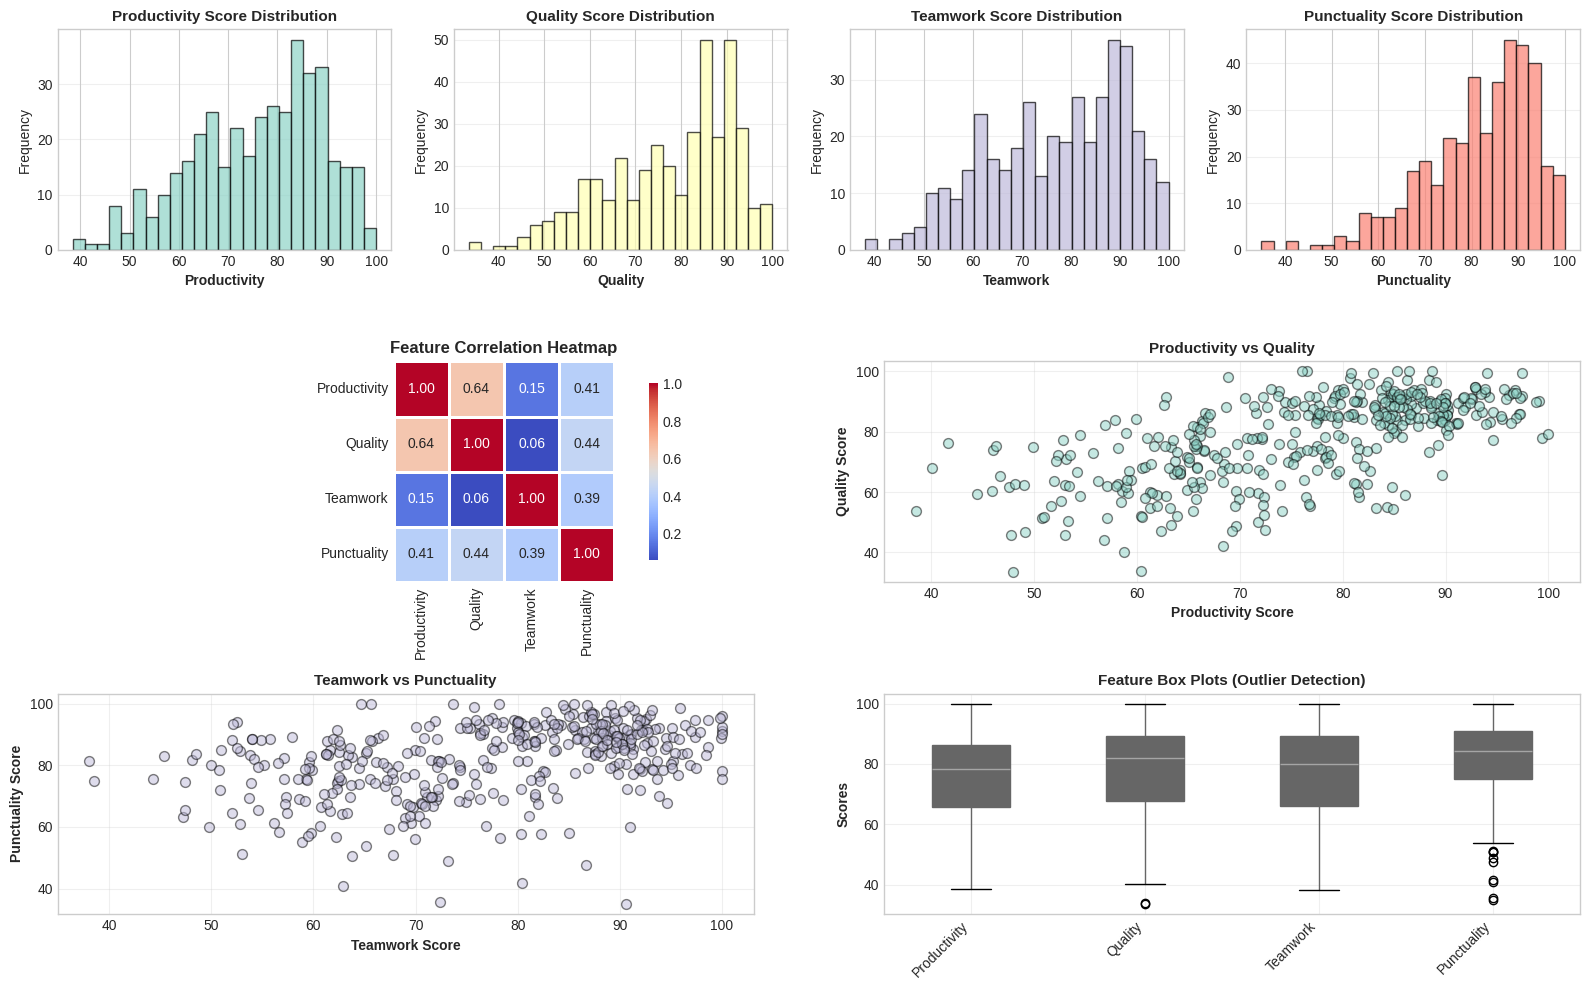

EDA INSIGHTS
• Productivity range: 38.5 to 100.0
• Quality range: 33.5 to 100.0
• Multiple peaks in distributions suggest overlapping groups
• Positive correlation between Productivity & Quality: 0.64
✓ EDA completed!


In [3]:
"""
=============================================================================
EXPLORATORY DATA ANALYSIS
=============================================================================
Visualizing employee performance distributions and feature relationships
=============================================================================
"""

# Create comprehensive EDA visualizations
fig = plt.figure(figsize=(16, 10))

# 1. Distribution plots for each feature
features = ['Productivity', 'Quality', 'Teamwork', 'Punctuality']
colors_dist = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072']

for i, (feature, color) in enumerate(zip(features, colors_dist), 1):
    plt.subplot(3, 4, i)
    plt.hist(df[feature], bins=25, color=color, edgecolor='black', alpha=0.7)
    plt.xlabel(feature, fontsize=10, fontweight='bold')
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'{feature} Score Distribution', fontsize=11, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

# 2. Correlation Heatmap
plt.subplot(3, 2, 3)
correlation_matrix = df[features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=2, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=12, fontweight='bold')

# 3. Productivity vs Quality
plt.subplot(3, 2, 4)
plt.scatter(df['Productivity'], df['Quality'], alpha=0.5, c='#8DD3C7',
            edgecolors='black', s=50)
plt.xlabel('Productivity Score', fontsize=10, fontweight='bold')
plt.ylabel('Quality Score', fontsize=10, fontweight='bold')
plt.title('Productivity vs Quality', fontsize=11, fontweight='bold')
plt.grid(alpha=0.3)

# 4. Teamwork vs Punctuality
plt.subplot(3, 2, 5)
plt.scatter(df['Teamwork'], df['Punctuality'], alpha=0.5, c='#BEBADA',
            edgecolors='black', s=50)
plt.xlabel('Teamwork Score', fontsize=10, fontweight='bold')
plt.ylabel('Punctuality Score', fontsize=10, fontweight='bold')
plt.title('Teamwork vs Punctuality', fontsize=11, fontweight='bold')
plt.grid(alpha=0.3)

# 5. Box plots for all features
plt.subplot(3, 2, 6)
df[features].boxplot(patch_artist=True)
plt.ylabel('Scores', fontsize=10, fontweight='bold')
plt.title('Feature Box Plots (Outlier Detection)', fontsize=11, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 70)
print("EDA INSIGHTS")
print("=" * 70)
print(f"• Productivity range: {df['Productivity'].min():.1f} to {df['Productivity'].max():.1f}")
print(f"• Quality range: {df['Quality'].min():.1f} to {df['Quality'].max():.1f}")
print(f"• Multiple peaks in distributions suggest overlapping groups")
print(f"• Positive correlation between Productivity & Quality: {correlation_matrix.loc['Productivity', 'Quality']:.2f}")
print("✓ EDA completed!")

In [4]:
"""
=============================================================================
DATA PREPROCESSING
=============================================================================
Standardizing features for GMM clustering. While GMM can handle different
scales better than K-means, standardization still improves convergence
and interpretability of results.
=============================================================================
"""

# Extract features for clustering (exclude Employee_ID)
X = df[['Productivity', 'Quality', 'Teamwork', 'Punctuality']].values

print("=" * 70)
print("DATA PREPROCESSING")
print("=" * 70)
print(f"\nOriginal Data Shape: {X.shape}")
print(f"Features: Productivity, Quality, Teamwork, Punctuality")

# Standardize the features (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✓ Data standardized successfully!")
print(f"\nBefore Standardization (first 5 employees):")
print(pd.DataFrame(X[:5], columns=['Productivity', 'Quality', 'Teamwork', 'Punctuality']))
print(f"\nAfter Standardization (first 5 employees):")
print(pd.DataFrame(X_scaled[:5], columns=['Productivity', 'Quality', 'Teamwork', 'Punctuality']))

# Verify standardization
print(f"\n--- Standardization Verification ---")
print(f"Mean of scaled features: {X_scaled.mean(axis=0).round(4)}")
print(f"Std of scaled features: {X_scaled.std(axis=0).round(4)}")
print("\n✓ Ready for Gaussian Mixture Models clustering!")

DATA PREPROCESSING

Original Data Shape: (400, 4)
Features: Productivity, Quality, Teamwork, Punctuality

✓ Data standardized successfully!

Before Standardization (first 5 employees):
   Productivity    Quality   Teamwork  Punctuality
0     90.980285  82.923146  87.504512    88.684020
1     87.170414  87.896773  88.925492    89.759276
2     91.886131  88.286427  92.581359    94.989174
3     97.138179  85.988614  92.376614    94.441481
4     86.595080  89.193571  75.356314    91.916394

After Standardization (first 5 employees):
   Productivity   Quality  Teamwork  Punctuality
0      1.130130  0.368712  0.738613     0.585753
1      0.841722  0.726610  0.840948     0.675928
2      1.198703  0.754649  1.104232     1.114531
3      1.596285  0.589301  1.089487     1.068599
4      0.798169  0.819927 -0.136263     0.856834

--- Standardization Verification ---
Mean of scaled features: [ 0.  0. -0. -0.]
Std of scaled features: [1. 1. 1. 1.]

✓ Ready for Gaussian Mixture Models clustering!


EVALUATING DIFFERENT NUMBER OF COMPONENTS
Components=2 | BIC: 4037.16 | AIC: 3921.40 | Log-Likelihood: -1931.70
Components=3 | BIC: 3964.08 | AIC: 3788.46 | Log-Likelihood: -1850.23
Components=4 | BIC: 3947.77 | AIC: 3712.27 | Log-Likelihood: -1797.14
Components=5 | BIC: 4017.09 | AIC: 3721.72 | Log-Likelihood: -1786.86
Components=6 | BIC: 4078.64 | AIC: 3723.40 | Log-Likelihood: -1772.70
Components=7 | BIC: 4135.98 | AIC: 3720.86 | Log-Likelihood: -1756.43
Components=8 | BIC: 4214.09 | AIC: 3739.11 | Log-Likelihood: -1750.55
Components=9 | BIC: 4259.57 | AIC: 3724.72 | Log-Likelihood: -1728.36
Components=10 | BIC: 4319.57 | AIC: 3724.84 | Log-Likelihood: -1713.42


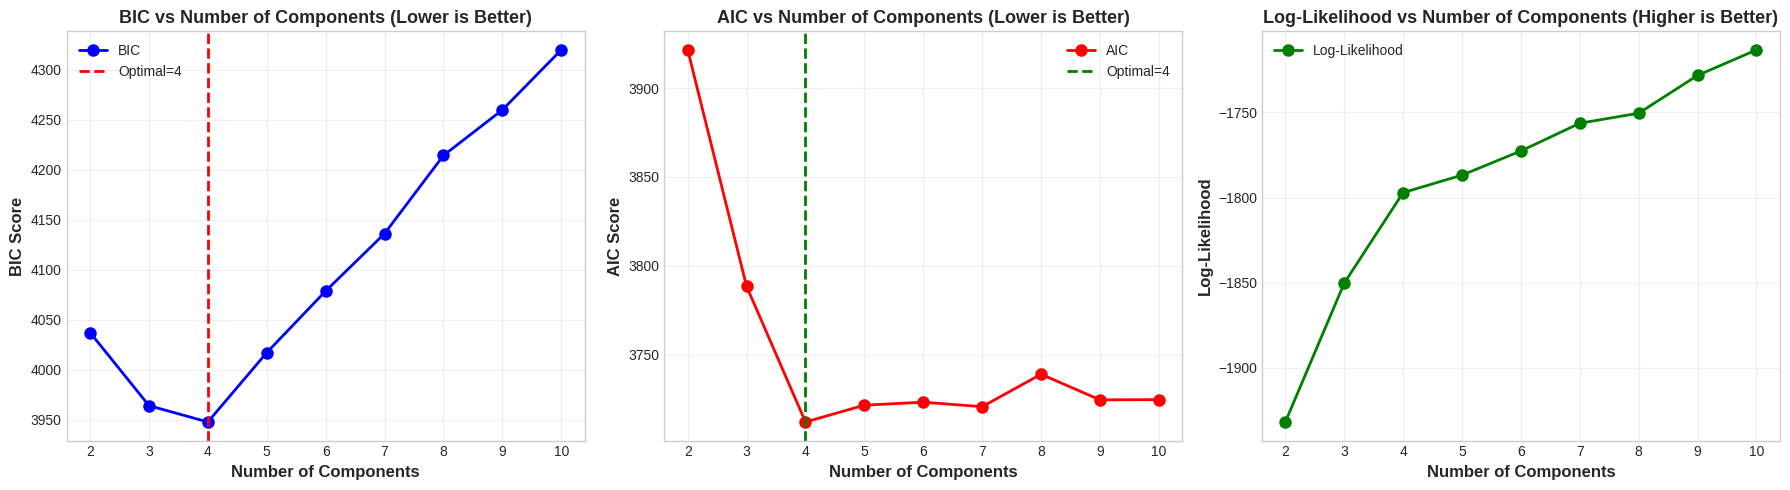


OPTIMAL COMPONENT DETERMINATION
✓ BIC suggests optimal components: 4
✓ AIC suggests optimal components: 4
✓ Proceeding with 4 components for final model


In [5]:
"""
=============================================================================
OPTIMAL NUMBER OF COMPONENTS - BIC & AIC CRITERION
=============================================================================
Testing different numbers of components (2-10) and evaluating with:
- BIC (Bayesian Information Criterion) - lower is better
- AIC (Akaike Information Criterion) - lower is better

These criteria balance model fit with complexity to avoid overfitting.
=============================================================================
"""

# Test different numbers of components
n_components_range = range(2, 11)
bic_scores = []
aic_scores = []
log_likelihoods = []

print("=" * 70)
print("EVALUATING DIFFERENT NUMBER OF COMPONENTS")
print("=" * 70)

for n_components in n_components_range:
    # Fit GMM with current number of components
    gmm = GaussianMixture(n_components=n_components,
                          covariance_type='full',
                          random_state=42,
                          n_init=10)
    gmm.fit(X_scaled)

    # Calculate BIC and AIC
    bic = gmm.bic(X_scaled)
    aic = gmm.aic(X_scaled)
    log_likelihood = gmm.score(X_scaled) * len(X_scaled)

    bic_scores.append(bic)
    aic_scores.append(aic)
    log_likelihoods.append(log_likelihood)

    print(f"Components={n_components} | BIC: {bic:.2f} | AIC: {aic:.2f} | Log-Likelihood: {log_likelihood:.2f}")

# Plot BIC and AIC scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: BIC Score
axes[0].plot(n_components_range, bic_scores, 'bo-', linewidth=2, markersize=8, label='BIC')
axes[0].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[0].set_ylabel('BIC Score', fontsize=12, fontweight='bold')
axes[0].set_title('BIC vs Number of Components (Lower is Better)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
optimal_bic = n_components_range[np.argmin(bic_scores)]
axes[0].axvline(x=optimal_bic, color='red', linestyle='--', linewidth=2, label=f'Optimal={optimal_bic}')
axes[0].legend(fontsize=10)

# Plot 2: AIC Score
axes[1].plot(n_components_range, aic_scores, 'ro-', linewidth=2, markersize=8, label='AIC')
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('AIC Score', fontsize=12, fontweight='bold')
axes[1].set_title('AIC vs Number of Components (Lower is Better)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
optimal_aic = n_components_range[np.argmin(aic_scores)]
axes[1].axvline(x=optimal_aic, color='green', linestyle='--', linewidth=2, label=f'Optimal={optimal_aic}')
axes[1].legend(fontsize=10)

# Plot 3: Log-Likelihood
axes[2].plot(n_components_range, log_likelihoods, 'go-', linewidth=2, markersize=8, label='Log-Likelihood')
axes[2].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Log-Likelihood', fontsize=12, fontweight='bold')
axes[2].set_title('Log-Likelihood vs Number of Components (Higher is Better)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("OPTIMAL COMPONENT DETERMINATION")
print("=" * 70)
print(f"✓ BIC suggests optimal components: {optimal_bic}")
print(f"✓ AIC suggests optimal components: {optimal_aic}")
print(f"✓ Proceeding with {optimal_bic} components for final model")

TRAINING GMM WITH 4 COMPONENTS

✓ Model trained successfully!
  - Number of components: 4
  - Covariance type: full (allows elliptical shapes)
  - Converged: True
  - Number of iterations: 7
  - Log-Likelihood: -1797.14

CLUSTER STATISTICS

--- Cluster 0 (107 employees) ---
Average Assignment Probability: 0.950
Productivity    87.509262
Quality         89.699932
Teamwork        85.154277
Punctuality     92.141759

--- Cluster 1 (96 employees) ---
Average Assignment Probability: 0.964
Productivity    84.273239
Quality         87.199307
Teamwork        64.066845
Punctuality     79.252271

--- Cluster 2 (103 employees) ---
Average Assignment Probability: 0.975
Productivity    60.522738
Quality         61.932932
Teamwork        68.457800
Punctuality     69.290805

--- Cluster 3 (94 employees) ---
Average Assignment Probability: 0.976
Productivity    71.627107
Quality         72.038038
Teamwork        91.343480
Punctuality     85.909213

CLUSTER DISTRIBUTION
Cluster
0    107
1     96
2    1

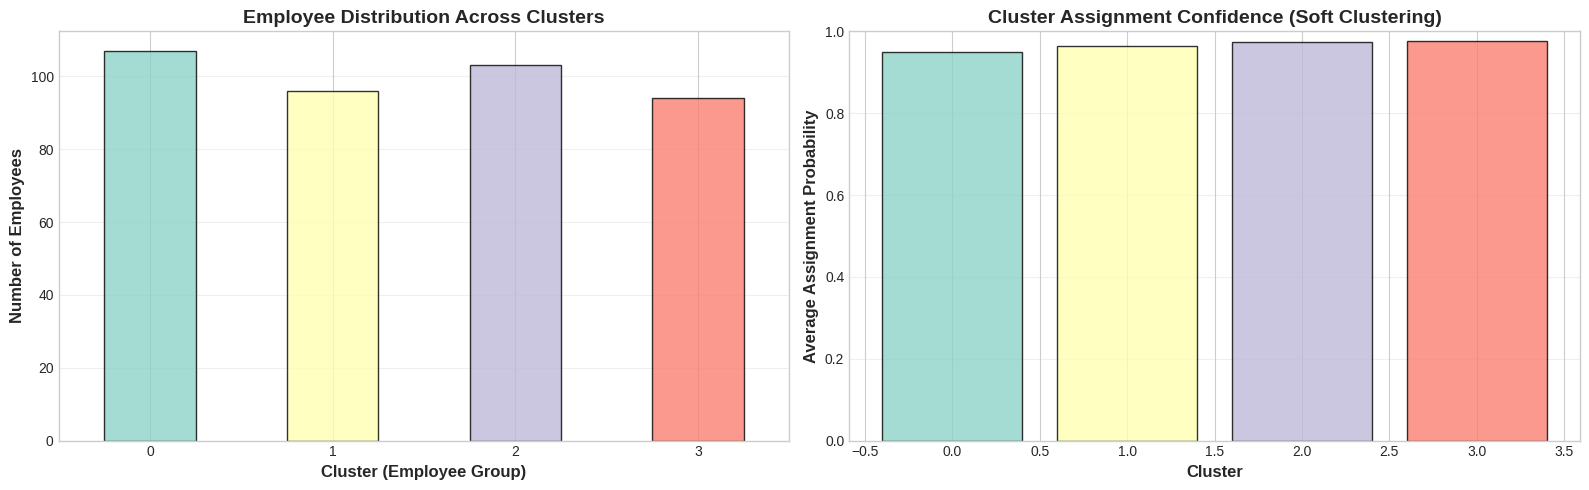


✓ Final model training completed!


In [6]:
"""
=============================================================================
TRAINING FINAL GMM MODEL
=============================================================================
Training Gaussian Mixture Model with optimal number of components
using full covariance to capture elliptical cluster shapes
=============================================================================
"""

# Use optimal number of components from BIC
optimal_n_components = n_components_range[np.argmin(bic_scores)]

print("=" * 70)
print(f"TRAINING GMM WITH {optimal_n_components} COMPONENTS")
print("=" * 70)

# Train final GMM model
gmm_final = GaussianMixture(n_components=optimal_n_components,
                            covariance_type='full',
                            random_state=42,
                            n_init=10,
                            max_iter=200)
gmm_final.fit(X_scaled)

# Get cluster assignments (hard clustering)
cluster_labels = gmm_final.predict(X_scaled)

# Get soft cluster assignments (probabilities)
cluster_probs = gmm_final.predict_proba(X_scaled)

# Add results to dataframe
df['Cluster'] = cluster_labels
df['Max_Probability'] = cluster_probs.max(axis=1)

print(f"\n✓ Model trained successfully!")
print(f"  - Number of components: {optimal_n_components}")
print(f"  - Covariance type: full (allows elliptical shapes)")
print(f"  - Converged: {gmm_final.converged_}")
print(f"  - Number of iterations: {gmm_final.n_iter_}")
print(f"  - Log-Likelihood: {gmm_final.score(X_scaled) * len(X_scaled):.2f}")

# Display cluster statistics
print(f"\n{'=' * 70}")
print("CLUSTER STATISTICS")
print("=" * 70)

for i in range(optimal_n_components):
    cluster_data = df[df['Cluster'] == i]
    avg_prob = cluster_data['Max_Probability'].mean()
    print(f"\n--- Cluster {i} ({len(cluster_data)} employees) ---")
    print(f"Average Assignment Probability: {avg_prob:.3f}")
    print(cluster_data[['Productivity', 'Quality', 'Teamwork', 'Punctuality']].mean().to_string())

# Cluster distribution
print(f"\n{'=' * 70}")
print("CLUSTER DISTRIBUTION")
print("=" * 70)
cluster_counts = df['Cluster'].value_counts().sort_index()
print(cluster_counts)

# Visualize cluster distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Cluster sizes
colors_bar = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072', '#80B1D3']
cluster_counts.plot(kind='bar', color=colors_bar[:optimal_n_components],
                    edgecolor='black', alpha=0.8, ax=ax1)
ax1.set_xlabel('Cluster (Employee Group)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Employees', fontsize=12, fontweight='bold')
ax1.set_title('Employee Distribution Across Clusters', fontsize=14, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Average assignment probability by cluster
avg_probs = [df[df['Cluster']==i]['Max_Probability'].mean() for i in range(optimal_n_components)]
ax2.bar(range(optimal_n_components), avg_probs, color=colors_bar[:optimal_n_components],
        edgecolor='black', alpha=0.8)
ax2.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Assignment Probability', fontsize=12, fontweight='bold')
ax2.set_title('Cluster Assignment Confidence (Soft Clustering)', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Final model training completed!")

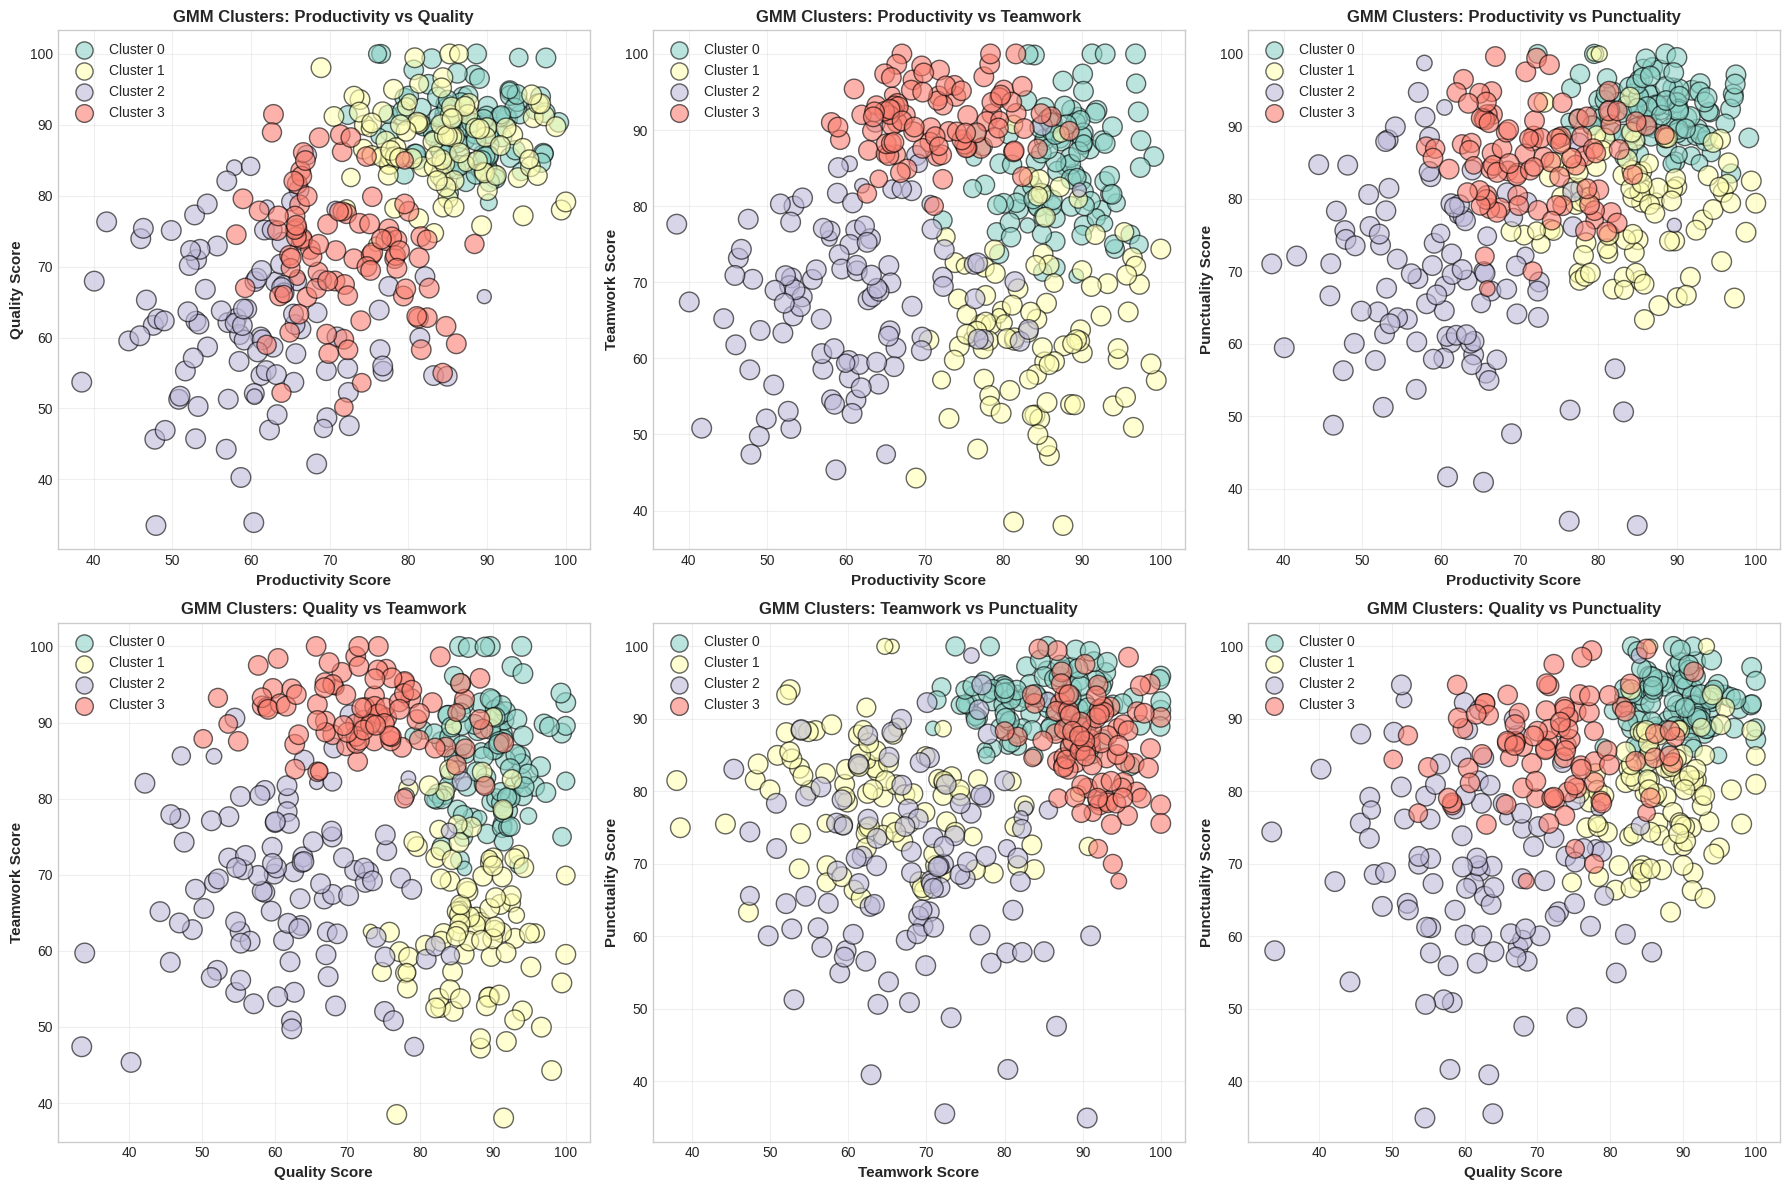

VISUALIZATION NOTE
• Point size represents assignment probability (larger = higher confidence)
• GMM allows soft clustering (probabilistic assignments)
• Overlapping regions show uncertainty between clusters
✓ Cluster visualization completed!


In [7]:
"""
=============================================================================
CLUSTER VISUALIZATION
=============================================================================
Visualizing GMM clusters using different feature combinations.
Points are colored by cluster and sized by assignment probability
to show soft clustering nature of GMM.
=============================================================================
"""

# Define colors for clusters
colors_cluster = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072', '#80B1D3']

fig = plt.figure(figsize=(18, 12))

# Plot 1: Productivity vs Quality
ax1 = plt.subplot(2, 3, 1)
for i in range(optimal_n_components):
    cluster_data = df[df['Cluster'] == i]
    scatter = plt.scatter(cluster_data['Productivity'], cluster_data['Quality'],
                         c=colors_cluster[i], label=f'Cluster {i}',
                         alpha=0.6, edgecolors='black',
                         s=cluster_data['Max_Probability']*200)
plt.xlabel('Productivity Score', fontsize=11, fontweight='bold')
plt.ylabel('Quality Score', fontsize=11, fontweight='bold')
plt.title('GMM Clusters: Productivity vs Quality', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Productivity vs Teamwork
ax2 = plt.subplot(2, 3, 2)
for i in range(optimal_n_components):
    cluster_data = df[df['Cluster'] == i]
    plt.scatter(cluster_data['Productivity'], cluster_data['Teamwork'],
                c=colors_cluster[i], label=f'Cluster {i}',
                alpha=0.6, edgecolors='black',
                s=cluster_data['Max_Probability']*200)
plt.xlabel('Productivity Score', fontsize=11, fontweight='bold')
plt.ylabel('Teamwork Score', fontsize=11, fontweight='bold')
plt.title('GMM Clusters: Productivity vs Teamwork', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Plot 3: Productivity vs Punctuality
ax3 = plt.subplot(2, 3, 3)
for i in range(optimal_n_components):
    cluster_data = df[df['Cluster'] == i]
    plt.scatter(cluster_data['Productivity'], cluster_data['Punctuality'],
                c=colors_cluster[i], label=f'Cluster {i}',
                alpha=0.6, edgecolors='black',
                s=cluster_data['Max_Probability']*200)
plt.xlabel('Productivity Score', fontsize=11, fontweight='bold')
plt.ylabel('Punctuality Score', fontsize=11, fontweight='bold')
plt.title('GMM Clusters: Productivity vs Punctuality', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Plot 4: Quality vs Teamwork
ax4 = plt.subplot(2, 3, 4)
for i in range(optimal_n_components):
    cluster_data = df[df['Cluster'] == i]
    plt.scatter(cluster_data['Quality'], cluster_data['Teamwork'],
                c=colors_cluster[i], label=f'Cluster {i}',
                alpha=0.6, edgecolors='black',
                s=cluster_data['Max_Probability']*200)
plt.xlabel('Quality Score', fontsize=11, fontweight='bold')
plt.ylabel('Teamwork Score', fontsize=11, fontweight='bold')
plt.title('GMM Clusters: Quality vs Teamwork', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Plot 5: Teamwork vs Punctuality
ax5 = plt.subplot(2, 3, 5)
for i in range(optimal_n_components):
    cluster_data = df[df['Cluster'] == i]
    plt.scatter(cluster_data['Teamwork'], cluster_data['Punctuality'],
                c=colors_cluster[i], label=f'Cluster {i}',
                alpha=0.6, edgecolors='black',
                s=cluster_data['Max_Probability']*200)
plt.xlabel('Teamwork Score', fontsize=11, fontweight='bold')
plt.ylabel('Punctuality Score', fontsize=11, fontweight='bold')
plt.title('GMM Clusters: Teamwork vs Punctuality', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Plot 6: Quality vs Punctuality
ax6 = plt.subplot(2, 3, 6)
for i in range(optimal_n_components):
    cluster_data = df[df['Cluster'] == i]
    plt.scatter(cluster_data['Quality'], cluster_data['Punctuality'],
                c=colors_cluster[i], label=f'Cluster {i}',
                alpha=0.6, edgecolors='black',
                s=cluster_data['Max_Probability']*200)
plt.xlabel('Quality Score', fontsize=11, fontweight='bold')
plt.ylabel('Punctuality Score', fontsize=11, fontweight='bold')
plt.title('GMM Clusters: Quality vs Punctuality', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 70)
print("VISUALIZATION NOTE")
print("=" * 70)
print("• Point size represents assignment probability (larger = higher confidence)")
print("• GMM allows soft clustering (probabilistic assignments)")
print("• Overlapping regions show uncertainty between clusters")
print("✓ Cluster visualization completed!")

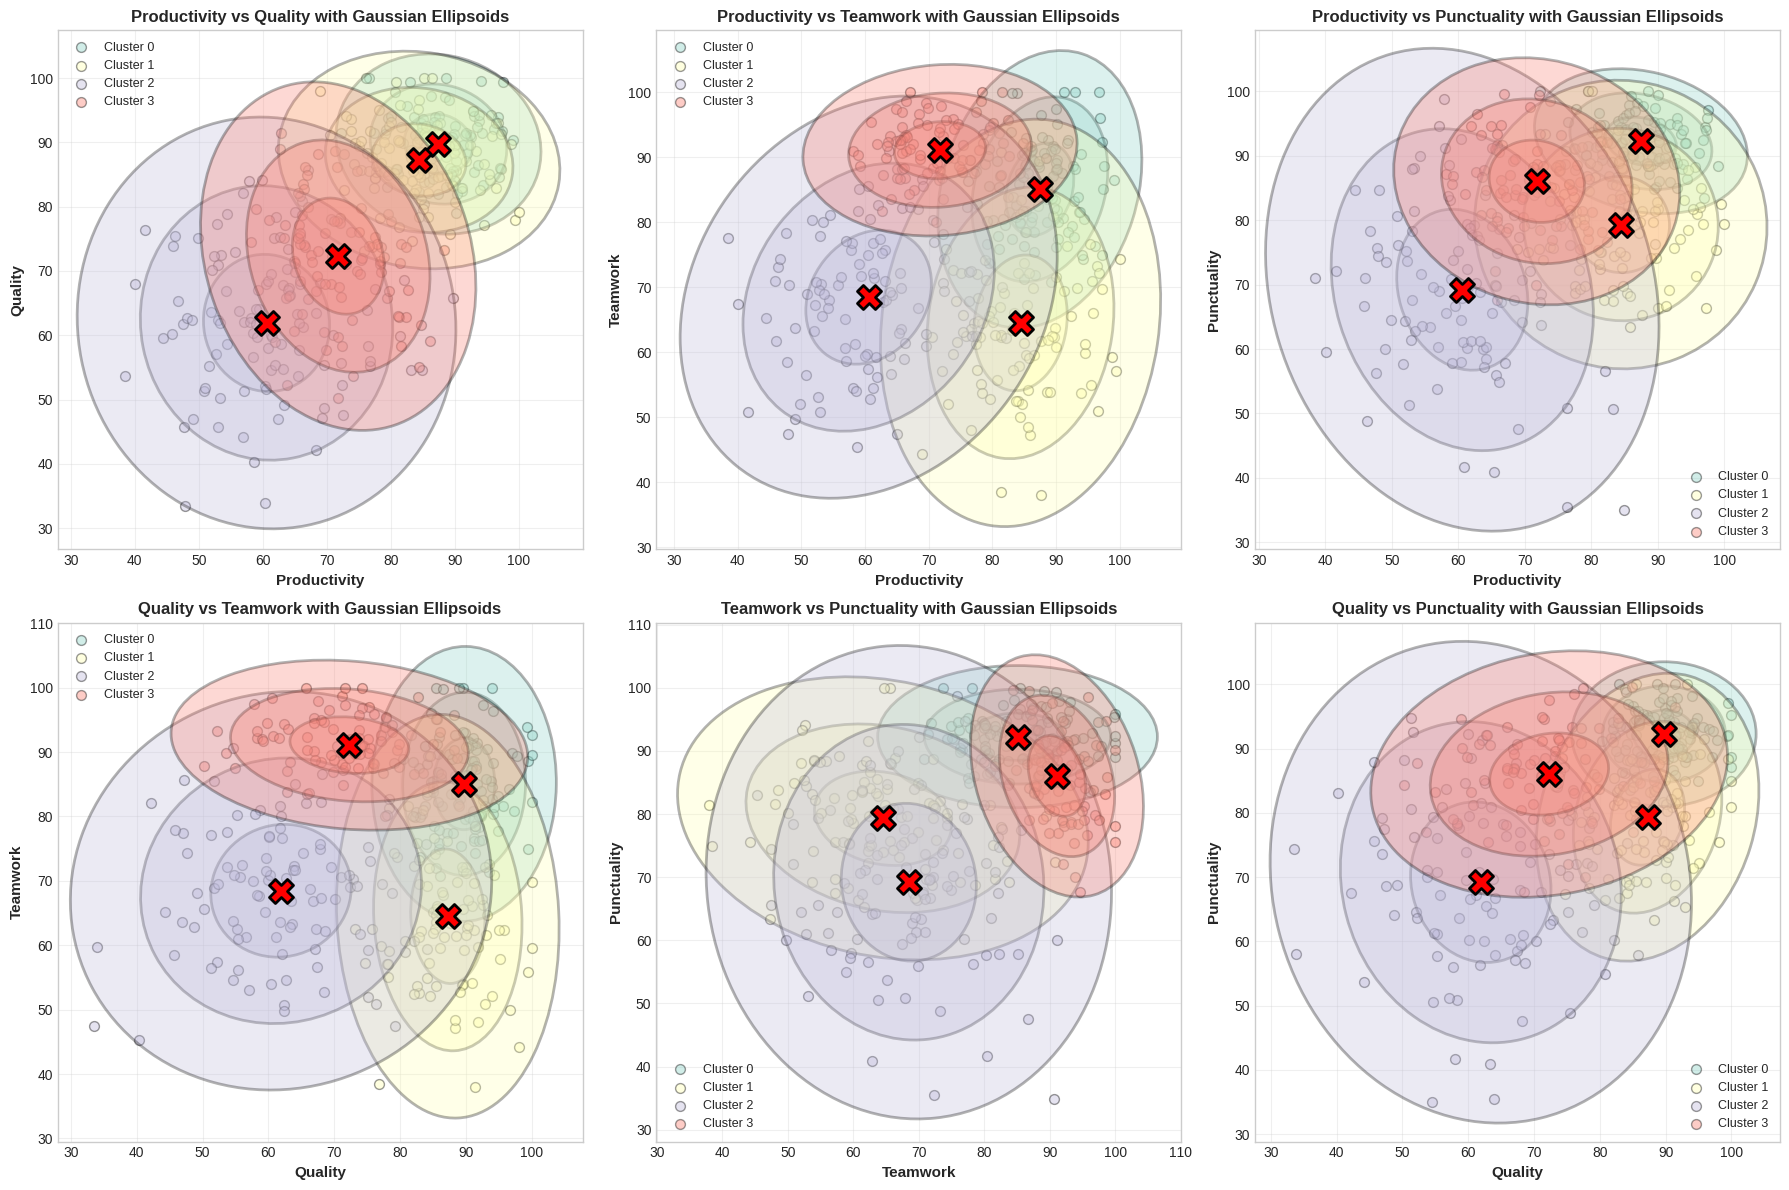

GAUSSIAN ELLIPSOIDS INTERPRETATION
• Red X markers: Cluster centers (means)
• Ellipsoids: Gaussian distributions (1σ, 2σ, 3σ contours)
• Ellipsoid shape shows covariance structure
• Overlapping ellipsoids indicate soft boundaries
• GMM captures non-spherical cluster shapes
✓ Ellipsoid visualization completed!


In [8]:
"""
=============================================================================
GAUSSIAN ELLIPSOIDS VISUALIZATION
=============================================================================
Visualizing the Gaussian components as ellipsoids to show the shape,
orientation, and overlap of each cluster's distribution.
This demonstrates GMM's ability to model non-spherical clusters.
=============================================================================
"""

from matplotlib.patches import Ellipse
from scipy import linalg

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                            angle=angle, **kwargs))

# Create 2D visualizations with ellipsoids
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

feature_pairs = [
    ('Productivity', 'Quality', 0, 1),
    ('Productivity', 'Teamwork', 0, 2),
    ('Productivity', 'Punctuality', 0, 3),
    ('Quality', 'Teamwork', 1, 2),
    ('Teamwork', 'Punctuality', 2, 3),
    ('Quality', 'Punctuality', 1, 3)
]

for idx, (feat1, feat2, dim1, dim2) in enumerate(feature_pairs):
    ax = axes[idx]

    # Plot data points
    for i in range(optimal_n_components):
        cluster_data = df[df['Cluster'] == i]
        ax.scatter(cluster_data[feat1], cluster_data[feat2],
                  c=colors_cluster[i], alpha=0.4, edgecolors='black',
                  s=50, label=f'Cluster {i}')

    # Plot Gaussian ellipsoids
    for i in range(optimal_n_components):
        # Get mean and covariance in original scale
        mean_scaled = gmm_final.means_[i][[dim1, dim2]]
        cov_scaled = gmm_final.covariances_[i][[dim1, dim2]][:, [dim1, dim2]]

        # Transform back to original scale
        mean_original = scaler.mean_[[dim1, dim2]] + mean_scaled * scaler.scale_[[dim1, dim2]]
        scale_matrix = np.diag(scaler.scale_[[dim1, dim2]])
        cov_original = scale_matrix @ cov_scaled @ scale_matrix.T

        draw_ellipse(mean_original, cov_original, ax=ax,
                    alpha=0.3, facecolor=colors_cluster[i],
                    edgecolor='black', linewidth=2)

        # Plot means
        ax.scatter(mean_original[0], mean_original[1],
                  marker='X', s=300, c='red', edgecolors='black',
                  linewidths=2, zorder=10)

    ax.set_xlabel(feat1, fontsize=11, fontweight='bold')
    ax.set_ylabel(feat2, fontsize=11, fontweight='bold')
    ax.set_title(f'{feat1} vs {feat2} with Gaussian Ellipsoids',
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 70)
print("GAUSSIAN ELLIPSOIDS INTERPRETATION")
print("=" * 70)
print("• Red X markers: Cluster centers (means)")
print("• Ellipsoids: Gaussian distributions (1σ, 2σ, 3σ contours)")
print("• Ellipsoid shape shows covariance structure")
print("• Overlapping ellipsoids indicate soft boundaries")
print("• GMM captures non-spherical cluster shapes")
print("✓ Ellipsoid visualization completed!")

CLUSTERING QUALITY METRICS

1. Silhouette Score: 0.3293
   → Interpretation: 0.3293 indicates moderate cluster separation
   → Range: -1 (worst) to 1 (best)

2. Davies-Bouldin Index: 1.0102
   → Interpretation: Lower is better (well-separated clusters)
   → Values closer to 0 indicate better clustering

3. Calinski-Harabasz Score: 227.23
   → Interpretation: Higher is better (dense, well-separated clusters)
   → Higher values indicate better defined clusters

4. BIC (Bayesian Information Criterion): 3947.77
   → Interpretation: Lower is better (balances fit and complexity)
   → Used for model selection

5. AIC (Akaike Information Criterion): 3712.27
   → Interpretation: Lower is better (balances fit and complexity)
   → Less penalty for complexity than BIC

6. Log-Likelihood: -1797.14
   → Interpretation: Higher is better (model fit to data)
   → Measures how well model explains the data


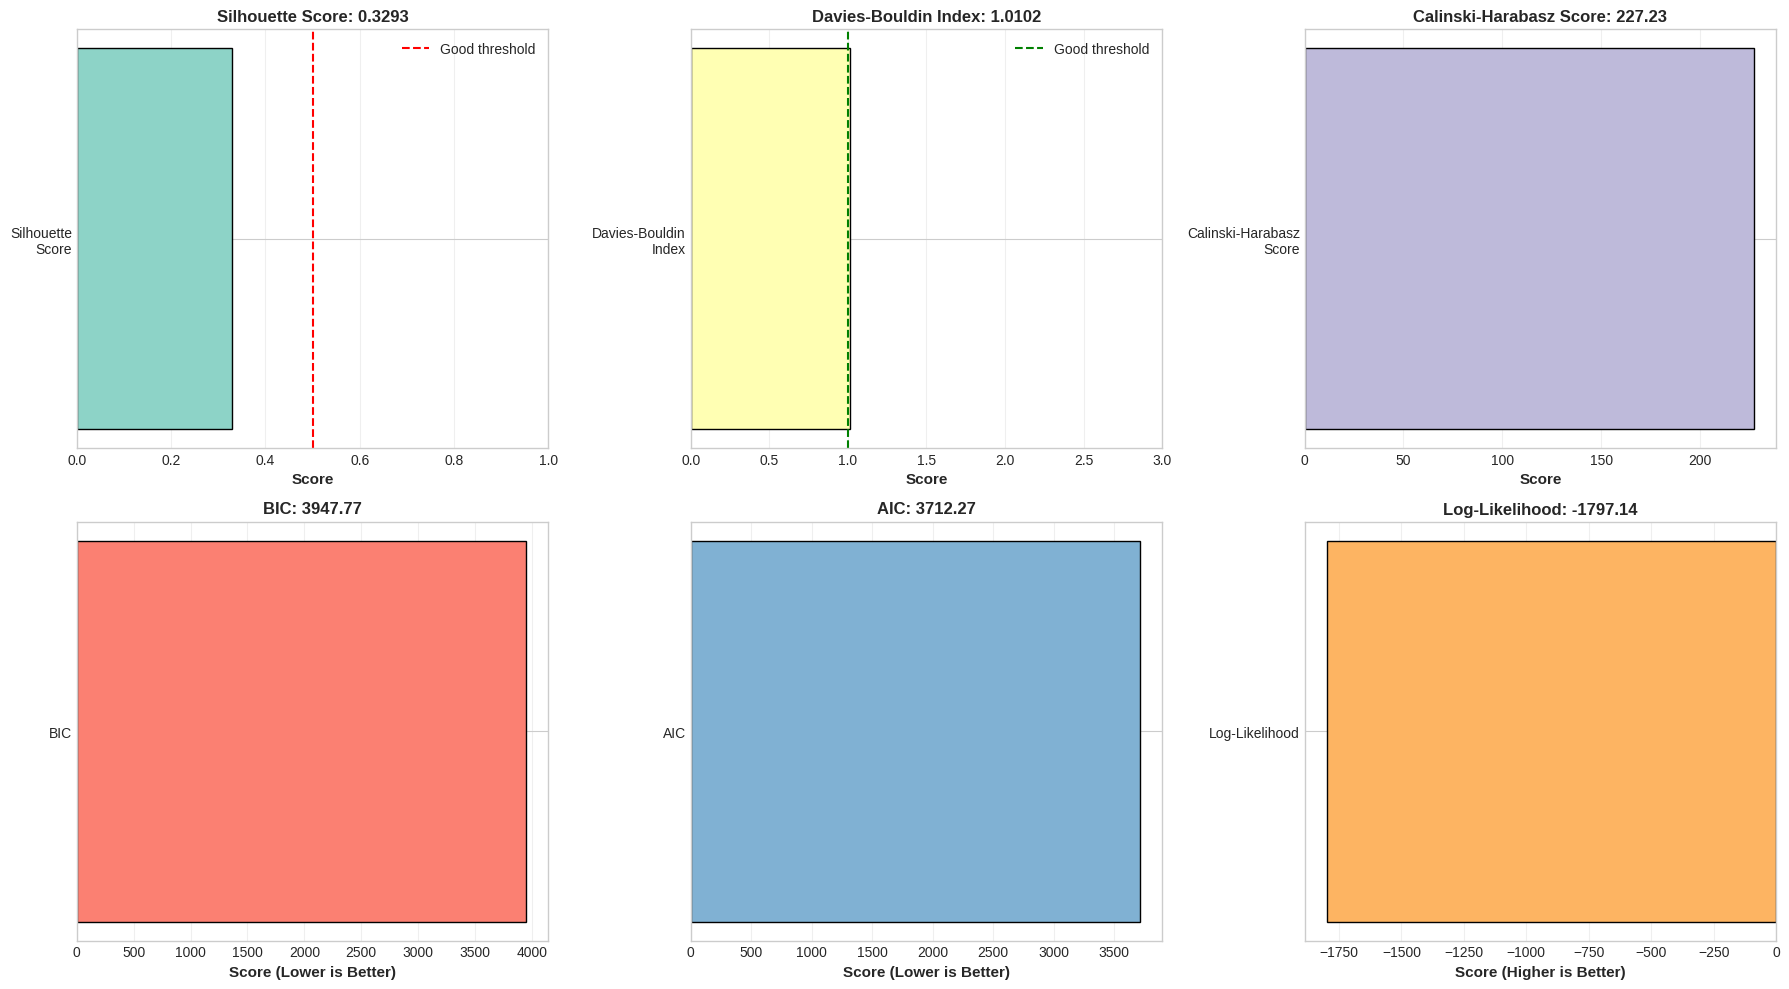


✓ Clustering quality evaluation completed!


In [9]:
"""
=============================================================================
CLUSTERING QUALITY EVALUATION
=============================================================================
Calculating comprehensive metrics to assess GMM clustering quality:
1. Silhouette Score (higher is better, range: -1 to 1)
2. Davies-Bouldin Index (lower is better)
3. Calinski-Harabasz Score (higher is better)
4. BIC and AIC (lower is better)
5. Log-Likelihood (higher is better)
=============================================================================
"""

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate evaluation metrics
silhouette = silhouette_score(X_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, cluster_labels)
bic = gmm_final.bic(X_scaled)
aic = gmm_final.aic(X_scaled)
log_likelihood = gmm_final.score(X_scaled) * len(X_scaled)

print("=" * 70)
print("CLUSTERING QUALITY METRICS")
print("=" * 70)

print(f"\n1. Silhouette Score: {silhouette:.4f}")
print(f"   → Interpretation: {silhouette:.4f} indicates {'excellent' if silhouette > 0.7 else 'good' if silhouette > 0.5 else 'moderate'} cluster separation")
print(f"   → Range: -1 (worst) to 1 (best)")

print(f"\n2. Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"   → Interpretation: Lower is better (well-separated clusters)")
print(f"   → Values closer to 0 indicate better clustering")

print(f"\n3. Calinski-Harabasz Score: {calinski_harabasz:.2f}")
print(f"   → Interpretation: Higher is better (dense, well-separated clusters)")
print(f"   → Higher values indicate better defined clusters")

print(f"\n4. BIC (Bayesian Information Criterion): {bic:.2f}")
print(f"   → Interpretation: Lower is better (balances fit and complexity)")
print(f"   → Used for model selection")

print(f"\n5. AIC (Akaike Information Criterion): {aic:.2f}")
print(f"   → Interpretation: Lower is better (balances fit and complexity)")
print(f"   → Less penalty for complexity than BIC")

print(f"\n6. Log-Likelihood: {log_likelihood:.2f}")
print(f"   → Interpretation: Higher is better (model fit to data)")
print(f"   → Measures how well model explains the data")

# Create visual summary of metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Metric 1: Silhouette Score
axes[0, 0].barh(['Silhouette\nScore'], [silhouette], color='#8DD3C7', edgecolor='black', height=0.5)
axes[0, 0].set_xlim(0, 1)
axes[0, 0].set_xlabel('Score', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'Silhouette Score: {silhouette:.4f}', fontsize=12, fontweight='bold')
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', label='Good threshold')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# Metric 2: Davies-Bouldin Index
axes[0, 1].barh(['Davies-Bouldin\nIndex'], [davies_bouldin], color='#FFFFB3', edgecolor='black', height=0.5)
axes[0, 1].set_xlim(0, max(3, davies_bouldin + 0.5))
axes[0, 1].set_xlabel('Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Davies-Bouldin Index: {davies_bouldin:.4f}', fontsize=12, fontweight='bold')
axes[0, 1].axvline(x=1.0, color='green', linestyle='--', label='Good threshold')
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)

# Metric 3: Calinski-Harabasz Score
axes[0, 2].barh(['Calinski-Harabasz\nScore'], [calinski_harabasz], color='#BEBADA', edgecolor='black', height=0.5)
axes[0, 2].set_xlabel('Score', fontsize=11, fontweight='bold')
axes[0, 2].set_title(f'Calinski-Harabasz Score: {calinski_harabasz:.2f}', fontsize=12, fontweight='bold')
axes[0, 2].grid(axis='x', alpha=0.3)

# Metric 4: BIC
axes[1, 0].barh(['BIC'], [bic], color='#FB8072', edgecolor='black', height=0.5)
axes[1, 0].set_xlabel('Score (Lower is Better)', fontsize=11, fontweight='bold')
axes[1, 0].set_title(f'BIC: {bic:.2f}', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# Metric 5: AIC
axes[1, 1].barh(['AIC'], [aic], color='#80B1D3', edgecolor='black', height=0.5)
axes[1, 1].set_xlabel('Score (Lower is Better)', fontsize=11, fontweight='bold')
axes[1, 1].set_title(f'AIC: {aic:.2f}', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

# Metric 6: Log-Likelihood
axes[1, 2].barh(['Log-Likelihood'], [log_likelihood], color='#FDB462', edgecolor='black', height=0.5)
axes[1, 2].set_xlabel('Score (Higher is Better)', fontsize=11, fontweight='bold')
axes[1, 2].set_title(f'Log-Likelihood: {log_likelihood:.2f}', fontsize=12, fontweight='bold')
axes[1, 2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✓ Clustering quality evaluation completed!")

DETAILED CLUSTER PROFILING

CLUSTER 0: Employee Group 0
Total Employees: 107
Percentage: 26.8%
Average Assignment Confidence: 0.950

--- Average Performance Scores ---
Productivity: 87.51 ± 5.35
Quality:      89.70 ± 4.71
Teamwork:     85.15 ± 6.84
Punctuality:  92.14 ± 3.70

--- Group Characteristics ---
• High Performers: Excellent across all metrics
• Leadership potential
• Top tier employees

CLUSTER 1: Employee Group 1
Total Employees: 96
Percentage: 24.0%
Average Assignment Confidence: 0.964

--- Average Performance Scores ---
Productivity: 84.27 ± 7.26
Quality:      87.20 ± 5.70
Teamwork:     64.07 ± 10.22
Punctuality:  79.25 ± 7.57

--- Group Characteristics ---
• Technical Specialists: Strong technical skills
• High productivity and quality
• May benefit from teamwork development

CLUSTER 2: Employee Group 2
Total Employees: 103
Percentage: 25.8%
Average Assignment Confidence: 0.975

--- Average Performance Scores ---
Productivity: 60.52 ± 9.97
Quality:      61.93 ± 10.81
Team

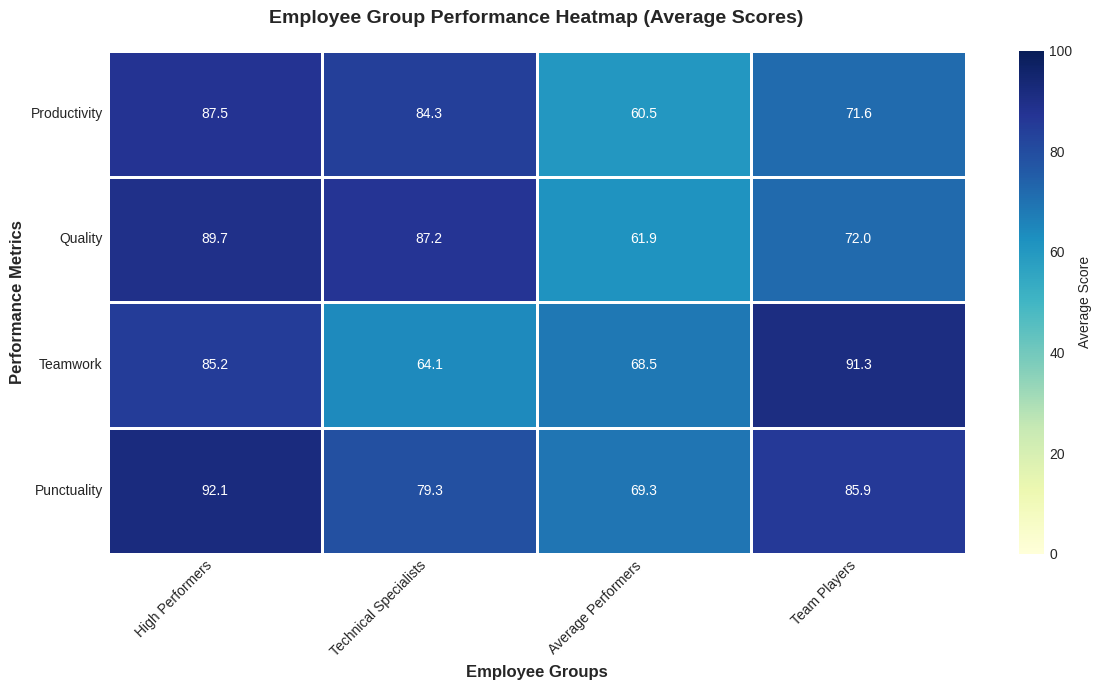


✓ Cluster profiling and interpretation completed!


In [10]:
"""
=============================================================================
CLUSTER PROFILING & INTERPRETATION
=============================================================================
Analyzing each cluster to understand employee group characteristics
and assign meaningful labels based on performance patterns
=============================================================================
"""

print("=" * 70)
print("DETAILED CLUSTER PROFILING")
print("=" * 70)

# Assign meaningful labels based on performance profiles
employee_groups = {}
for i in range(optimal_n_components):
    employee_groups[i] = f"Employee Group {i}"

# Analyze each cluster
for cluster_id in range(optimal_n_components):
    cluster_data = df[df['Cluster'] == cluster_id]
    avg_prob = cluster_data['Max_Probability'].mean()

    print(f"\n{'=' * 70}")
    print(f"CLUSTER {cluster_id}: {employee_groups[cluster_id]}")
    print(f"{'=' * 70}")
    print(f"Total Employees: {len(cluster_data)}")
    print(f"Percentage: {len(cluster_data)/len(df)*100:.1f}%")
    print(f"Average Assignment Confidence: {avg_prob:.3f}")

    print(f"\n--- Average Performance Scores ---")
    print(f"Productivity: {cluster_data['Productivity'].mean():.2f} ± {cluster_data['Productivity'].std():.2f}")
    print(f"Quality:      {cluster_data['Quality'].mean():.2f} ± {cluster_data['Quality'].std():.2f}")
    print(f"Teamwork:     {cluster_data['Teamwork'].mean():.2f} ± {cluster_data['Teamwork'].std():.2f}")
    print(f"Punctuality:  {cluster_data['Punctuality'].mean():.2f} ± {cluster_data['Punctuality'].std():.2f}")

    # Determine group characteristics
    prod_avg = cluster_data['Productivity'].mean()
    qual_avg = cluster_data['Quality'].mean()
    team_avg = cluster_data['Teamwork'].mean()
    punc_avg = cluster_data['Punctuality'].mean()

    print(f"\n--- Group Characteristics ---")
    if prod_avg > 80 and qual_avg > 80 and team_avg > 80:
        print("• High Performers: Excellent across all metrics")
        print("• Leadership potential")
        print("• Top tier employees")
        employee_groups[cluster_id] = "High Performers"
    elif prod_avg > 80 and qual_avg > 80 and team_avg < 75:
        print("• Technical Specialists: Strong technical skills")
        print("• High productivity and quality")
        print("• May benefit from teamwork development")
        employee_groups[cluster_id] = "Technical Specialists"
    elif team_avg > 80 and prod_avg < 75:
        print("• Team Players: Excellent collaboration")
        print("• Strong teamwork skills")
        print("• May benefit from technical skill development")
        employee_groups[cluster_id] = "Team Players"
    else:
        print("• Average Performers: Moderate performance")
        print("• Development opportunities available")
        print("• May benefit from training programs")
        employee_groups[cluster_id] = "Average Performers"

# Create heatmap of cluster profiles
fig, ax = plt.subplots(figsize=(12, 7))

# Prepare data for heatmap (mean values)
heatmap_data = df.groupby('Cluster')[['Productivity', 'Quality', 'Teamwork', 'Punctuality']].mean()
heatmap_data.index = [f"{employee_groups[i]}" for i in heatmap_data.index]

sns.heatmap(heatmap_data.T, annot=True, fmt='.1f', cmap='YlGnBu',
            linewidths=2, cbar_kws={'label': 'Average Score'},
            vmin=0, vmax=100, ax=ax)
plt.title('Employee Group Performance Heatmap (Average Scores)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Employee Groups', fontsize=12, fontweight='bold')
plt.ylabel('Performance Metrics', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✓ Cluster profiling and interpretation completed!")

SOFT CLUSTERING ANALYSIS

Employees with high confidence (prob >= 0.7): 387 (96.8%)
Employees with uncertain assignment (prob < 0.7): 13 (3.2%)

--- Assignment Probability Statistics ---
Mean probability: 0.966
Min probability: 0.508
Max probability: 1.000
Std deviation: 0.082

--- Sample Uncertain Employees (showing top 5) ---

EMP_0248:
  Assigned to Cluster 2 with probability 0.508
  All probabilities: C0:0.000 C1:0.086 C2:0.508 C3:0.406 

EMP_0145:
  Assigned to Cluster 1 with probability 0.529
  All probabilities: C0:0.000 C1:0.529 C2:0.471 C3:0.000 

EMP_0037:
  Assigned to Cluster 0 with probability 0.537
  All probabilities: C0:0.537 C1:0.463 C2:0.000 C3:0.000 

EMP_0156:
  Assigned to Cluster 1 with probability 0.539
  All probabilities: C0:0.460 C1:0.539 C2:0.001 C3:0.000 

EMP_0238:
  Assigned to Cluster 2 with probability 0.545
  All probabilities: C0:0.000 C1:0.005 C2:0.545 C3:0.450 


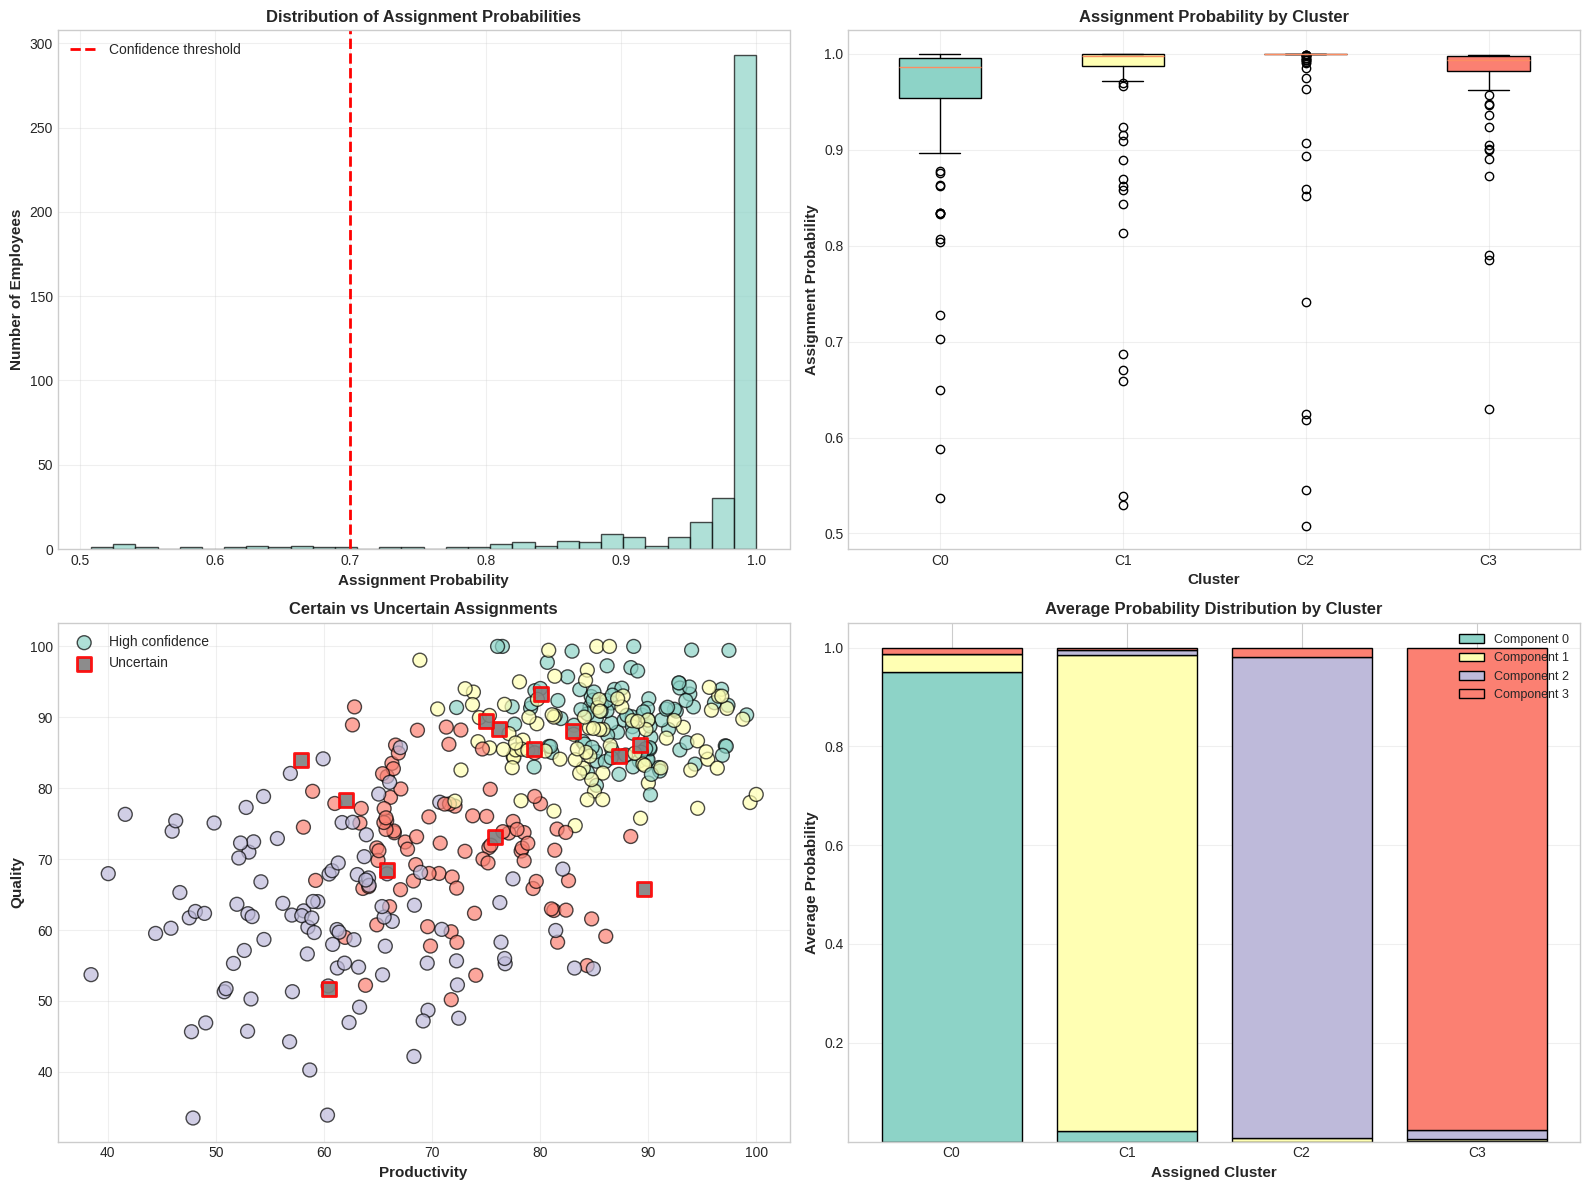


SOFT CLUSTERING INSIGHTS
• GMM provides probabilistic cluster assignments
• Uncertain employees may belong to multiple groups
• Useful for identifying boundary cases
• Helps in nuanced decision-making
✓ Soft clustering analysis completed!


In [11]:
"""
=============================================================================
SOFT vs HARD CLUSTERING COMPARISON
=============================================================================
Demonstrating GMM's unique soft clustering capability by showing
probabilistic assignments vs hard cluster labels.
=============================================================================
"""

print("=" * 70)
print("SOFT CLUSTERING ANALYSIS")
print("=" * 70)

# Find employees with uncertain assignments (probability < 0.7)
uncertain_employees = df[df['Max_Probability'] < 0.7].copy()
certain_employees = df[df['Max_Probability'] >= 0.7].copy()

print(f"\nEmployees with high confidence (prob >= 0.7): {len(certain_employees)} ({len(certain_employees)/len(df)*100:.1f}%)")
print(f"Employees with uncertain assignment (prob < 0.7): {len(uncertain_employees)} ({len(uncertain_employees)/len(df)*100:.1f}%)")

# Show probability distribution across all employees
print(f"\n--- Assignment Probability Statistics ---")
print(f"Mean probability: {df['Max_Probability'].mean():.3f}")
print(f"Min probability: {df['Max_Probability'].min():.3f}")
print(f"Max probability: {df['Max_Probability'].max():.3f}")
print(f"Std deviation: {df['Max_Probability'].std():.3f}")

# Display sample uncertain employees with their probabilities
if len(uncertain_employees) > 0:
    print(f"\n--- Sample Uncertain Employees (showing top 5) ---")
    sample_uncertain = uncertain_employees.nsmallest(5, 'Max_Probability')
    for idx, row in sample_uncertain.iterrows():
        probs = cluster_probs[idx]
        print(f"\n{row['Employee_ID']}:")
        print(f"  Assigned to Cluster {row['Cluster']} with probability {row['Max_Probability']:.3f}")
        print(f"  All probabilities: ", end="")
        for i, prob in enumerate(probs):
            print(f"C{i}:{prob:.3f} ", end="")
        print()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Probability distribution histogram
axes[0, 0].hist(df['Max_Probability'], bins=30, color='#8DD3C7',
                edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0.7, color='red', linestyle='--', linewidth=2,
                   label='Confidence threshold')
axes[0, 0].set_xlabel('Assignment Probability', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Number of Employees', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribution of Assignment Probabilities',
                     fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Box plot of probabilities by cluster
cluster_probs_by_group = [df[df['Cluster']==i]['Max_Probability'].values
                          for i in range(optimal_n_components)]
bp = axes[0, 1].boxplot(cluster_probs_by_group, labels=[f'C{i}' for i in range(optimal_n_components)],
                        patch_artist=True)
for patch, color in zip(bp['boxes'], colors_cluster):
    patch.set_facecolor(color)
axes[0, 1].set_xlabel('Cluster', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Assignment Probability', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Assignment Probability by Cluster',
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Scatter showing certain vs uncertain employees
axes[1, 0].scatter(certain_employees['Productivity'], certain_employees['Quality'],
                  c=certain_employees['Cluster'].map({i: colors_cluster[i] for i in range(optimal_n_components)}),
                  alpha=0.7, edgecolors='black', s=100, label='High confidence')
axes[1, 0].scatter(uncertain_employees['Productivity'], uncertain_employees['Quality'],
                  c='gray', alpha=0.9, edgecolors='red', s=100,
                  linewidths=2, marker='s', label='Uncertain')
axes[1, 0].set_xlabel('Productivity', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Quality', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Certain vs Uncertain Assignments',
                     fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Stacked bar showing probability distributions
prob_matrix = np.zeros((optimal_n_components, optimal_n_components))
for i in range(optimal_n_components):
    cluster_employees = df[df['Cluster'] == i]
    for j in range(optimal_n_components):
        prob_matrix[i, j] = cluster_probs[cluster_employees.index, j].mean()

bottom = np.zeros(optimal_n_components)
for j in range(optimal_n_components):
    axes[1, 1].bar(range(optimal_n_components), prob_matrix[:, j],
                  bottom=bottom, label=f'Component {j}',
                  color=colors_cluster[j], edgecolor='black')
    bottom += prob_matrix[:, j]

axes[1, 1].set_xlabel('Assigned Cluster', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Average Probability', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Average Probability Distribution by Cluster',
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(range(optimal_n_components))
axes[1, 1].set_xticklabels([f'C{i}' for i in range(optimal_n_components)])
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("SOFT CLUSTERING INSIGHTS")
print("=" * 70)
print("• GMM provides probabilistic cluster assignments")
print("• Uncertain employees may belong to multiple groups")
print("• Useful for identifying boundary cases")
print("• Helps in nuanced decision-making")
print("✓ Soft clustering analysis completed!")

In [12]:
"""
=============================================================================
FINAL SUMMARY AND RESULTS EXPORT
=============================================================================
Summarizing all findings and saving the clustered dataset
=============================================================================
"""

print("=" * 70)
print("GAUSSIAN MIXTURE MODELS (GMM) - FINAL SUMMARY")
print("=" * 70)

print("\n📊 DATASET INFORMATION")
print(f"  • Total Employees: {len(df)}")
print(f"  • Features Used: Productivity, Quality, Teamwork, Punctuality")
print(f"  • Optimal Components: {optimal_n_components}")

print("\n🎯 CLUSTERING RESULTS")
print(f"  • Algorithm: Gaussian Mixture Models (EM Algorithm)")
print(f"  • Covariance Type: Full (allows elliptical shapes)")
print(f"  • Converged: {gmm_final.converged_}")
print(f"  • Number of Iterations: {gmm_final.n_iter_}")
print(f"  • Clustering Type: Soft clustering (probabilistic)")

print("\n📈 QUALITY METRICS")
print(f"  • Silhouette Score: {silhouette:.4f}")
print(f"  • Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"  • Calinski-Harabasz Score: {calinski_harabasz:.2f}")
print(f"  • BIC: {bic:.2f} (model selection criterion)")
print(f"  • AIC: {aic:.2f} (model selection criterion)")
print(f"  • Log-Likelihood: {log_likelihood:.2f}")

print("\n👥 EMPLOYEE GROUP DISTRIBUTION")
for i in range(optimal_n_components):
    count = len(df[df['Cluster'] == i])
    percentage = count/len(df)*100
    avg_confidence = df[df['Cluster'] == i]['Max_Probability'].mean()
    print(f"  • {employee_groups[i]}: {count} employees ({percentage:.1f}%) - Avg confidence: {avg_confidence:.3f}")

print("\n🔍 KEY INSIGHTS")
print(f"  • Successfully identified {optimal_n_components} distinct employee performance groups")
print(f"  • Soft clustering reveals {len(uncertain_employees)} employees with uncertain assignments")
print(f"  • GMM captures overlapping performance patterns")
print(f"  • Elliptical cluster shapes better fit real performance data")
print(f"  • Probabilistic assignments enable nuanced talent management")

# Display sample employees from each cluster
print("\n" + "=" * 70)
print("SAMPLE EMPLOYEES FROM EACH GROUP")
print("=" * 70)
for i in range(optimal_n_components):
    print(f"\n{employee_groups[i]}:")
    sample = df[df['Cluster'] == i][['Employee_ID', 'Productivity', 'Quality',
                                      'Teamwork', 'Punctuality', 'Cluster',
                                      'Max_Probability']].head(3)
    print(sample.to_string(index=False))

# Save results to CSV
output_filename = 'employee_performance_gmm_clustering.csv'
df.to_csv(output_filename, index=False)

# Also save the soft clustering probabilities
df_with_probs = df.copy()
for i in range(optimal_n_components):
    df_with_probs[f'Prob_Cluster_{i}'] = cluster_probs[:, i]

output_filename_probs = 'employee_performance_gmm_with_probabilities.csv'
df_with_probs.to_csv(output_filename_probs, index=False)

print("\n" + "=" * 70)
print(f"✓ Results saved to: {output_filename}")
print(f"✓ Results with probabilities saved to: {output_filename_probs}")
print("=" * 70)
print("\n🎉 GAUSSIAN MIXTURE MODELS CLUSTERING - COMPLETED SUCCESSFULLY!")
print("=" * 70)

GAUSSIAN MIXTURE MODELS (GMM) - FINAL SUMMARY

📊 DATASET INFORMATION
  • Total Employees: 400
  • Features Used: Productivity, Quality, Teamwork, Punctuality
  • Optimal Components: 4

🎯 CLUSTERING RESULTS
  • Algorithm: Gaussian Mixture Models (EM Algorithm)
  • Covariance Type: Full (allows elliptical shapes)
  • Converged: True
  • Number of Iterations: 7
  • Clustering Type: Soft clustering (probabilistic)

📈 QUALITY METRICS
  • Silhouette Score: 0.3293
  • Davies-Bouldin Index: 1.0102
  • Calinski-Harabasz Score: 227.23
  • BIC: 3947.77 (model selection criterion)
  • AIC: 3712.27 (model selection criterion)
  • Log-Likelihood: -1797.14

👥 EMPLOYEE GROUP DISTRIBUTION
  • High Performers: 107 employees (26.8%) - Avg confidence: 0.950
  • Technical Specialists: 96 employees (24.0%) - Avg confidence: 0.964
  • Average Performers: 103 employees (25.8%) - Avg confidence: 0.975
  • Team Players: 94 employees (23.5%) - Avg confidence: 0.976

🔍 KEY INSIGHTS
  • Successfully identified 4 d